In [1]:
# Importing packages
import pandas as pd                                                       # DataFrame
from matplotlib import pyplot as plt                                      # Plotting
from sklearn.model_selection import train_test_split                      # Split our Data into Train and Split
from sklearn.metrics import mean_squared_error, mean_absolute_error       # Evaluating the Performance of our Model
import xgboost as xgb                                                     # Time series library of XGBoost
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV   # New import we need for this week

In [2]:
# Import Google Colab file directory
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Load the train dataset
df_train = pd.read_csv('/content/drive/MyDrive/newtrain.csv')
display(df_train.head())

,id,date,store_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,2511.619,NaN
1,1,2013-01-02,1,7417.148,NaN
2,2,2013-01-02,2,10266.719,NaN
3,3,2013-01-02,3,24060.348,NaN
4,4,2013-01-02,4,10200.084,NaN


In [4]:
# Resetting missing values in the 'onpromotion' column
df_train.loc[:, 'onpromotion'] = df_train['onpromotion'].fillna(False)
df_train.head()

/tmp/ipython-input-3791830797.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_train.loc[:, 'onpromotion'] = df_train['onpromotion'].fillna(False)
/tmp/ipython-input-3791830797.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ... False False False]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_train.loc[:, 'onpromotion'] = df_train['onpromotion'].fillna(False)


,id,date,store_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,2511.619,False
1,1,2013-01-02,1,7417.148,False
2,2,2013-01-02,2,10266.719,False
3,3,2013-01-02,3,24060.348,False
4,4,2013-01-02,4,10200.084,False


In [5]:
# Convert 'date' column to datetime format
df_train['date'] = pd.to_datetime(df_train['date'])

# Check formatting of dataframe
display(df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83606 entries, 0 to 83605
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           83606 non-null  int64         
 1   date         83606 non-null  datetime64[ns]
 2   store_nbr    83606 non-null  int64         
 3   unit_sales   83606 non-null  float64       
 4   onpromotion  83606 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 2.6 MB


None

# This was from last week's Colab File

In [6]:
# Converting boolean to integers
# using apply() to set up function where x represents the value (1 = True, 0 = False)
df_train['onpromotion'] = df_train['onpromotion'].apply(lambda x: 1 if x == True else 0)
print(df_train['onpromotion'])

0        0
1        0
2        0
3        0
4        0
        ..
83601    0
83602    0
83603    0
83604    0
83605    0
Name: onpromotion, Length: 83606, dtype: int64


In [7]:
# Creating training and testing datasets (simulate real world forecasting)
# Train is on or before 01MAR2014
# Test is after 01MAR2014
split_date = '2014-03-01'
train = df_train[df_train['date'] <= split_date]  # Remember we need to train the historical data ...
test = df_train[df_train['date'] > split_date]    # ... to test the future

In [8]:
# Define target variable (unit_sales) and features
X_train = train.drop(['unit_sales', 'id'], axis=1)
X_train = X_train.drop('date', axis=1)
y_train = train['unit_sales']

X_test = test.drop(['unit_sales', 'id'], axis=1)
X_test = X_test.drop('date', axis=1)
y_test = test['unit_sales']

In [9]:
# Initialize the XGBoost regressor model
xgboost_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    enable_categorical=True
)

# objective='reg:squarederror' => penalizes large errors, minimize MSE
# n_estimator=100 => number of decision trees
# max_depth=5 => size of the dataset we are training (3 as simple to 10+ not recommended)
# learning_rate=0.1 => how much each decision tree contributes to the prediction (keeps it stable)
# enable_categorical=True => enables the model to handle categorical data (will not help with prediction)

# A rule: increase of n_estimators means decrease the learning_rate

# Train the XGBoost model
xgboost_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [10]:
# After training the model, we are now testing the predictions
y_pred = xgboost_model.predict(X_test)

Calculating the errors:

Root Mean Squared Error (RMSE)
- On average, how far off are my predictions
- Penalizes larger errors more heavily (i.e. outliers)

Mean Absolute Error (MAE)
- How far off are my predictions
- Treats all errors equally

In [11]:
print("RMSE:", mean_squared_error(y_true=y_test, y_pred=y_pred))
print("MAE:", mean_absolute_error(y_true=y_test, y_pred=y_pred))

RMSE: 78321797.58629283
MAE: 5861.541184848763


We are now visualizing our baseline model

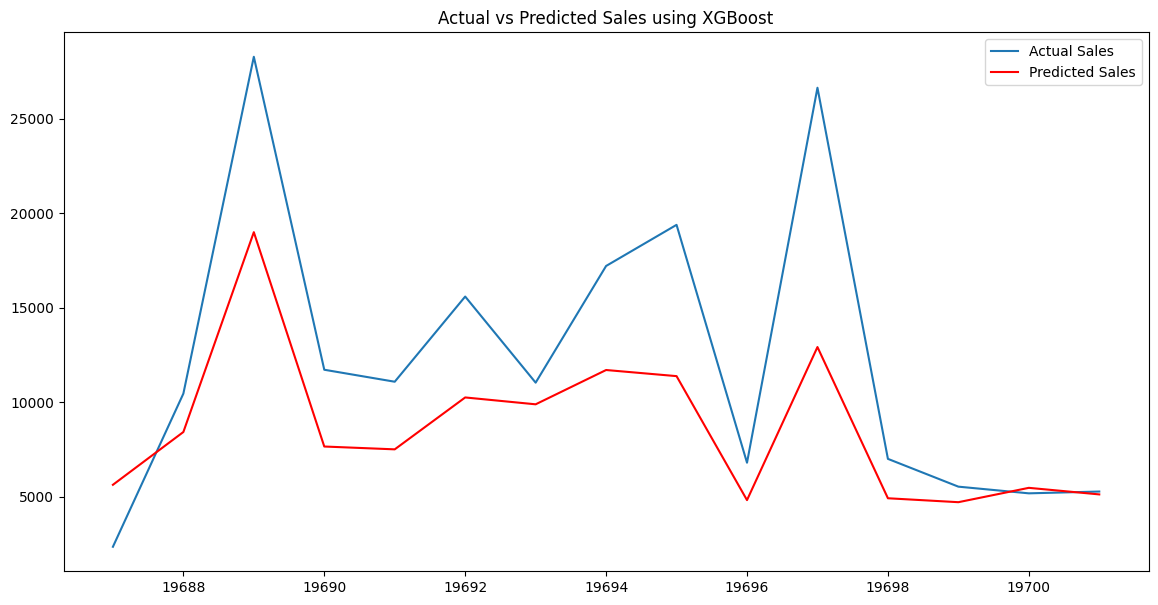

In [12]:
i = 15 # number of days to plot
plt.figure(figsize=(14, 7))
plt.plot(y_test.index[:i], y_test.values[:i], label='Actual Sales')
plt.plot(y_test.index[:i], y_pred[:i], label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using XGBoost')
plt.legend()
plt.show()

# This is new coding that we will work on to expand on what we looked at last week

We are going to utilize this baseline model and see if we can make some improvements. To do this, we are going to use the RandomizedSearchCV and TimeSeriesSplit portions.

In [18]:
# Initializing the model (getting it started)
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror')

# Defining the parameter grid, by trying 3 options for each parameter (you can change the values)
param_grid = {
    'eta': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'n_estimators': [100, 200, 300]
}

# eta => How fast the model learns
# max_depth => How deep each decision tree can grow
# subsample => Fraction of data to use for each tree
# colsample_bytree => Fraction of features to use for each tree
# n_estimators => Number of decision trees to build

# Time series split for cross-validation (no need to change this)
tscv = TimeSeriesSplit(n_splits=5)

# Randomized search with cross-validation (tries random parameter combinations)
random_search = RandomizedSearchCV(estimator=xgboost_model,
                                   param_distributions=param_grid,
                                   cv=tscv,
                                   n_iter=10,
                                   scoring='neg_mean_squared_error' # this is the metric we want to improve
                                  )

# Fit the model and search for the best hyperparameters (in this instance, we are trying out 50 models = n_splits x n_iter)
random_search.fit(X_train, y_train)

# Get best hyperparameters
best_params = random_search.best_params_
print("Best Parameters for XGBoost:", best_params)

Best Parameters for XGBoost: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'eta': 0.3, 'colsample_bytree': 1.0}


In [20]:
# Using the values above to put into the XGBRegressor model below
best_model = random_search.best_estimator_
best_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.3, eval_metric=None,
             feature_types=None, feature_weights=None, gamma=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None, ...)

In [21]:
# Like before, we will make predictions on the test set
y_pred = best_model.predict(X_test)

In [22]:
print("RMSE:", mean_squared_error(y_true=y_test, y_pred=y_pred))    # View the RMSE Error
print("MAE:", mean_absolute_error(y_true=y_test, y_pred=y_pred))    # View the MAE Error

# Overall, there was not much of an improvement

MSE: 78023438.00558843
MAE: 5856.449848003406


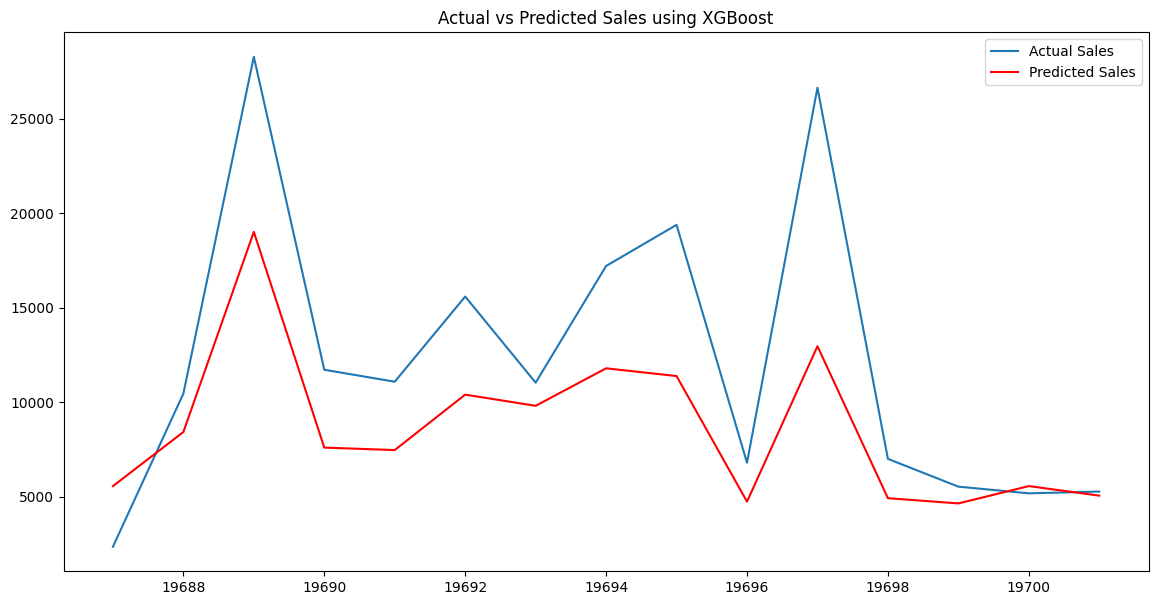

In [23]:
# Providing an updated plot
i = 15 # number of days to plot
plt.figure(figsize=(14, 7))
plt.plot(y_test.index[:i], y_test.values[:i], label='Actual Sales')
plt.plot(y_test.index[:i], y_pred[:i], label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using XGBoost')
plt.legend()
plt.show()

It is ok because maybe this is not the ideal model to use. You may have to try out another model (maybe the ones we looked at before)

Try out the other models or adjust/edit the current model to see if you receive different results

Remember ... do not worry if the model is inaccurate. It is difficult for this to occur. The goal is to train and test your model to be as accurate as possible. It will NEVER be perfect or ideal.